In [1]:
import cProfile
import os
import statistics as st
import plotly.graph_objects as go
import random as rd
import time
import pandas as pd
import math
from collections import defaultdict
import numpy as np
import itertools as it
import Utilities.experiment_utils as eu
import unit_test as ut
import Games.mnk as mnk
import Games.Carcassonne.Carcassonne as carc
#import Games.carcassonne_older as csn
import Agents.random as arand
import Agents.vanilla_mcts as mcts
import Agents.siea_mcts as siea_mcts
import Agents.mcts_rave as rave_mcts
import Agents.one_step_lookahead as osla
import Agents.mcts_solver as mcts_solver
import Games.function_optimisation as fo
import Utilities.logs_management as lm
import Games.chess_64 as chess_64
import chess
import matplotlib.pyplot as plt
import shutil
import itertools

#cProfile.run("wins =  random_games(10000, base_gs)")
#ut.run()

import scipy.stats

def t(alpha, gl):
    return scipy.stats.t.ppf(1-(alpha/2), gl)
#https://stackoverflow.com/questions/67340028/how-to-use-t-ppf-which-are-the-arguments
#https://stackoverflow.com/questions/40294844/calculate-t-student-test-for-the-next-table-in-python
#https://www.geeksforgeeks.org/python-students-t-distribution-in-statistics/
#https://itl.nist.gov/div898/handbook/eda/section3/eda352.htm
#https://docs.tibco.com/data-science/GUID-8E64444A-5F5B-49F9-A43A-74B13647AFB4.html#:~:text=The%20larger%20the%20variation%2C%20the%20less%20reliable%20the,sample%20size%20is%20large%2C%20say%20n%3D100%20or%20more.

In [ ]:
#Experiment chess default policy

def default_policy_puzzles(puzzles, agents, games):
    for puzzle_row in puzzles:
        game_state = chess_64.GameState()
        game_state.set_puzzle_lichess_db(puzzle_row)
        final_df = pd.DataFrame()
        for agent in agents:
            start_time = time.time()
            fm_calls= []
            game_length = []
            total_decisive = 0
            white_wins = 0
            corrects = 0
            for game_id in range(games):
                duplicate_state = game_state.duplicate()
                total_fm = 0
                turns = 0
                while not duplicate_state.is_terminal:
                    move = agent.choose_action(duplicate_state)
                    duplicate_state.make_action(move)
                    total_fm += agent.current_fm + 1
                    turns += 1
                if duplicate_state.winner is not None:
                    total_decisive += 1
                    if duplicate_state.winner == 0:
                        white_wins += 1
                    if duplicate_state.winner == game_state.player_turn:
                        corrects += 1
                fm_calls.append(total_fm)
                game_length.append(turns)
            correct_in_decisive_ratio = corrects/total_decisive if total_decisive != 0 else None
            df = pd.DataFrame({"agent": [agent.name], "avg_fm_calls": [st.mean(fm_calls)], "std_fm_calls":[st.stdev(fm_calls)], "avg_game_length": [st.mean(game_length)], "std_game_length":[st.stdev(game_length)], "games": [games], "decisive_rate": [total_decisive/games], "white_wins":[white_wins/games], "avg_game_time": [(time.time() - start_time)/games], "correct_in_decisive_ratio": [correct_in_decisive_ratio],"correct_in_all_ratio": [corrects/games], "player_to_win": [game_state.player_turn]})
            df = pd.concat([df, agent.agent_data()], axis = 1)
            df = pd.concat([df, game_state.logs_data()], axis = 1)
            row_frame = puzzle_row.to_frame().T
            row_frame.index = [0]
            df = pd.concat([df, row_frame], axis = 1)
            final_df = pd.concat([final_df, df])
        print("Finished puzzle " + str(puzzle_row["PuzzleId"]))
        #final_df.to_csv(os.path.join("Outputs","Comparison_default_policies","Chess_" + str(puzzle_row["PuzzleId"]) + "_games" + str(games) + ".csv"), index = False)
        lm.dump_data(data = final_df, file_path = os.path.join("Outputs","Comparison_default_policies"), file_name = "Chess_Puzzle_" + str(puzzle_row["PuzzleId"]) + "_games" + str(games) + ".csv")

lichess_db = pd.read_csv("Datasets/lichess_db_puzzle_subsample.csv")
puzzles = []
puzzles_idx = [3]
for pidx in puzzles_idx:
    puzzles.append(lichess_db.iloc[pidx])
agents = [osla.OSLA_Wins(max_probing_size=1), osla.OSLA_Wins(max_probing_size=2), osla.OSLA_Wins(), arand.RandomPlayer()]
games = 10

#default_policy_puzzles(puzzles, agents, games)
#cProfile.run("default_policy_puzzles(puzzles, agents, games)")
game_state = chess_64.GameState()
game_state.set_puzzle_lichess_db(puzzles[0])
print(puzzles[0]["FEN"])
print(puzzles[0]["PuzzleId"])
game_state.board

Game: chess_puzzle
Agent: mcts_solver
Move to look for: e5e4
Moves to look for: f5f2 e5e4 g5g6 e4e3 f2c2 d3c2 g6g7 e3e2 g7g8q e2e1q
advancedPawn endgame mate mateIn5 promotion quietMove rookEndgame veryLong
N available_moves: 5
Player: 1


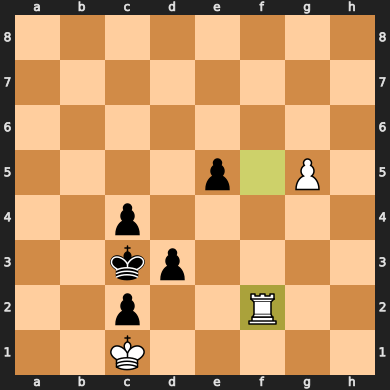

In [2]:
#View tree on each iteration - STEP 1

#parameters
game_idx = 5
agent_idx = 3
agent_rollouts = 1
#puzzle_idx = 66 #matein3
puzzle_idx = 62
#max_iterations = 0
max_iterations = 0
iterations_logs_step = 10

#database
games = ["chess", "ttt", "carcassonne", "carcassonne_1", "carcassonne_discard","chess_puzzle", "ttt_setup"]
game = games[game_idx]
print("Game:", game)
agent_types = ["mcts", "rave_mcts", "siea_mcts", "mcts_solver", "siea_mcts2"]
agent_type = agent_types[agent_idx]
print("Agent:", agent_type)

#agent definition
if agent_type == "mcts":
    mcts_agent = mcts.MCTS_Player(max_iterations = max_iterations, rollouts=agent_rollouts)
elif agent_type == "rave_mcts":
    mcts_agent = rave_mcts.MCTS_RAVE(max_iterations = max_iterations, rollouts=agent_rollouts)
elif agent_type == "siea_mcts":
    mcts_agent = siea_mcts.SIEA_MCTS_Player(max_iterations = max_iterations, rollouts=agent_rollouts)
elif agent_type == "mcts_solver":
    mcts_agent = mcts_solver.MCTS_Solver(max_iterations = max_iterations, rollouts=agent_rollouts)
elif agent_type == "siea_mcts2":
    mcts_agent = siea_mcts.SIEA_MCTS_Player(name = "siea_mcts2", max_iterations = max_iterations, rollouts=agent_rollouts, unpaired_evolution=True)

#game definition
if game == "chess":
    game_state = chess_64.GameState()
    game_state.set_initial_state()
elif game == "ttt":
    game_state = mnk.GameState(3,3,3)
    game_state.set_initial_state()
elif game == "ttt_setup":
    game_state = mnk.GameState(3,3,3)
    game_state.set_board(board_items = {(1,1):0, 
                                    (0,0):0, 
                                    (2,2):1, 
                                    (0,1):1,
                                    #(1,0):0
                                    }, player_turn = 0)
elif game == "carcassonne":
    game_state = carc.CarcassonneState()
    game_state.set_initial_state()
elif game == "carcassonne_1":
    game_state = carc.CarcassonneState(initial_tile_quantities=[1 for _ in range(24)])
    game_state.set_initial_state()
elif game == "carcassonne_discard":
    game_state = carc.CarcassonneState(initial_tile_quantities=[1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0])
    game_state.set_initial_state()
elif game == "chess_puzzle":
    game_state = chess_64.GameState()
    #Load lichess dataset
    lichess_db = pd.read_csv("Datasets/mates_processed_lichess_db_puzzle.csv")
    #lichess_db = pd.read_csv("Datasets/lichess_db_puzzle_subsample.csv")
    #lichess_db = pd.read_csv("Datasets/lichess_1000_most_played.csv")
    
    puzzle_row = lichess_db.iloc[puzzle_idx]
    game_state.set_puzzle_lichess_db(puzzle_row)
    print("Move to look for:", puzzle_row["Moves"].split(" ")[1])
    print("Moves to look for:", puzzle_row["Moves"])
    print(puzzle_row["Themes"])
    
#game_state.view_game_state()

#Initialize mcts agent
if max_iterations == 0:
    random_action = mcts_agent.choose_action(game_state)
    print("N available_moves:", len(game_state.available_actions))
    #print("Root node:", mcts_agent.view_mcts_tree())
    #game_state.view_game_state()
    print("Player:",mcts_agent.player)
else:
    mcts_agent.choose_action(game_state)
    print("Current decision node: ", mcts_agent.recommendation_policy())
    print("Iterations: ", mcts_agent.current_iterations)
    print("FM calls: ", mcts_agent.current_fm)
    #print(mcts_agent.view_mcts_tree())
    print(mcts_agent.view_action_stats())
    #print(mcts_agent.view_proven_tree())
    if "siea" in agent_type:
        print("Evolution fm calls: ", mcts_agent.evolution_fm_calls)
    print("Node count: ", mcts_agent.nodes_count)
game_state.board
    

In [3]:
#View tree on each iteration - STEP 2 - Iterate

#By iteration
iterations = 5000
def run_iteration(iterations):
    for it in range(iterations):
        mcts_agent.iteration()
#run_iteration(iterations)
#cProfile.run("run_iteration(iterations)")

#By_choose_action
def run_choose_action():
    mcts_agent.max_iterations = iterations
    mcts_agent.choose_action(game_state)
run_choose_action()

print("Iterations: ", mcts_agent.current_iterations)
print("FM calls: ", mcts_agent.current_fm)
print("Recommended action: ", mcts_agent.recommendation_policy())
#print(mcts_agent.view_mcts_tree())
print(mcts_agent.view_action_stats())
print(mcts_agent.view_proven_tree())

Iterations:  5000
FM calls:  689284
Recommended action:  Black:e5e4

0:Decision_node, edge:None, visits:5000, avg_rwd:0.0926, children:5,from:5
1:Decision_node, edge:Black:c3b3, visits:1004, avg_rwd:0.0886, children:14,from:14, tree_policy_formula:0.219
2:Decision_node, edge:Black:e5e4, visits:1888, avg_rwd:0.124, children:13,from:13, tree_policy_formula:0.219
3:Decision_node, edge:Black:c3b4, visits:1052, avg_rwd:0.0922, children:15,from:15, tree_policy_formula:0.219
4:Decision_node, edge:Black:d3d2, visits:392, avg_rwd:0.0102, children:1,from:1, tree_policy_formula:0.219
5:Decision_node, edge:Black:c3d4, visits:664, avg_rwd:0.0587, children:15,from:15, tree_policy_formula:0.219

0:Decision_node, edge:None, visits:5000, avg_rwd:0.0926, children:5,from:5, tree_policy:Nonechildren:5


Puzzle found at index: 99
Unnamed: 0                                                         99
PuzzleId                                                        006x0
FEN                  3Q4/5kr1/8/1P2pB2/2Pp1n2/q2P3P/7K/5R2 w - - 7 49
Moves                                             d8d7 f7f6 d7d8 f6f5
Rating                                                           1366
RatingDeviation                                                   172
Popularity                                                        100
NbPlays                                                            16
Themes                           defensiveMove endgame equality short
GameUrl                               https://lichess.org/yJzYpNj0#97
OpeningTags                                                       NaN
Available_actions                                                   4
Pieces                                                             14
Theme_count                                                     

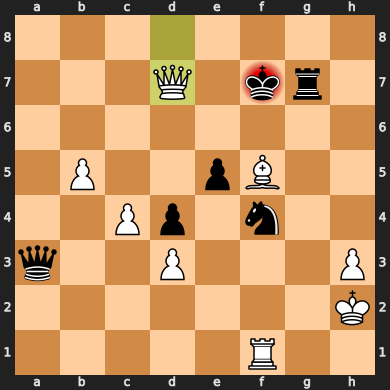

In [8]:
#Puzzle search
by_criteria=True
#tags_to_include = ["crushing", "pawnEndgame"]
tags_to_include = ["endgame", "equality"]
tags_to_remove = ["oneMove"]
#tags_to_remove = ["middlegame","opening","mateIn5","mateIn1","oneMove","veryLong"]

#theme = "pawnEndgame"
#theme = "pin"
next_puzzle = 0
#random_one = True
#puzzle_idx = 183#121
puzzle_id = "000Vc"

#lichess_db = pd.read_csv("Datasets/lichess_1000_most_played.csv")
#lichess_db = pd.read_csv("Datasets/lichess_db_puzzle_subsample.csv")
lichess_db = pd.read_csv("Datasets/processed_lichess_db_puzzle.csv")
#lichess_db = pd.read_csv("Datasets/pawnendgames_processed_lichess_db_puzzle.csv")

puzzles_found = -1
if by_criteria:
    for puzzle_idx, puzzle_row in lichess_db.iterrows():
        row_tags = puzzle_row["Themes"].split(" ")
        if len(set(row_tags).intersection(set(tags_to_include))) == len(tags_to_include):
            if len(set(row_tags).intersection(set(tags_to_remove))) == 0:
                #print(row_tags)
                puzzles_found += 1
                if puzzles_found == next_puzzle:
                    print("Puzzle found at index:", puzzle_idx)
                    break
else:
    if puzzle_id is not None:
        puzzle_row = lichess_db.loc[lichess_db["PuzzleId"] == puzzle_id]
        puzzle_idx = puzzle_row.index[0]
        print("Puzzle found at index:", puzzle_idx)
        
game_state = chess_64.GameState()
#puzzle_row = lichess_db.iloc[puzzle_idx]
game_state.set_puzzle_lichess_db(puzzle_row)
#print("Move to look for:", puzzle_row["Moves"].split(" ")[1])
#print("Moves to look for:", puzzle_row["Moves"])
print(str(puzzle_row))
print(puzzle_row["Moves"])
print(puzzle_row["Themes"])
game_state.board

In [4]:
#Create lichess db subsets
dataset_file = "processed_lichess_db_puzzle.csv"
dataset_path = "Datasets"
lichess_db = pd.read_csv(os.path.join(dataset_path, dataset_file))
#max_puzzles = 100
#min_per_tag = 10

#filtering by tags
tags_to_avoid = ["mateIn1", "oneMove", "opening", "mateIn2", "mateIn3", "mateIn4", "mateIn5", "mate"]
tags_to_include = ["pawnEndgame"]#["mateIn5","mateIn4","mateIn3","mateIn2"]#,
#tags_to_include_after = ["endgame"]
tags_to_include_after = ["crushing", "equality", "sacrifice"]

add_list = [True for _ in range(len(lichess_db))]
for row_idx, row in lichess_db.iterrows():
    row_tags = row["Themes"].split(" ")

    #tags to include
    if len(set(row_tags).intersection(set(tags_to_include))) < 1:
        add_list[row_idx] = False
        continue

    if len(set(row_tags).intersection(set(tags_to_include_after))) < 1:
        add_list[row_idx] = False
        continue

    #tags to avoid
    for tag in tags_to_avoid:
        if tag in row_tags:
            add_list[row_idx] = False
            break
    if not add_list[row_idx]:
        continue
lichess_db = lichess_db[add_list]
print(len(lichess_db), "puzzles after filtering by tags")

#Filtering by other
lichess_db = lichess_db[lichess_db["Pieces"] < 10]
print(len(lichess_db), "puzzles after filtering by pieces")
lichess_db = lichess_db[lichess_db["Available_actions"] < 10]
print(len(lichess_db), "puzzles after filtering by available_actions")
lichess_db = lichess_db[lichess_db["NbPlays"] > 1000]
print(len(lichess_db), "puzzles after filtering by NbPlays")
lichess_db = lichess_db[lichess_db["Required_moves"] <= 3]
print(len(lichess_db), "puzzles after filtering by Required_moves")

#save subset to csv
new_dataset_name = "pawnendgames_" + dataset_file
lm.dump_data(data = lichess_db, file_path = dataset_path, file_name = new_dataset_name)

#analyse the dataset by tag
tag_analysis = eu.analyse_puzzles_by_tag(lichess_db)
lm.dump_data(data = tag_analysis, file_path = dataset_path, file_name = "tags_of_" + new_dataset_name)


88661 puzzles after filtering by tags
38638 puzzles after filtering by pieces
34749 puzzles after filtering by available_actions
8388 puzzles after filtering by NbPlays
5759 puzzles after filtering by Required_moves


,appearance_ratio,count,average_rating,std_rating,average_available_moves,std_available_moves,average_nb_plays,std_nb_plays,pieces,std_pieces,tag_count,std_tag_count,required_moves,required_moves_std_depth


In [5]:
#Create lichess db subsets detailed
dataset_file = "processed_lichess_db_puzzle.csv"
dataset_path = "Datasets"
lichess_db = pd.read_csv(os.path.join(dataset_path, dataset_file))

#filtering by tags
tags_to_avoid = ["mateIn1", "oneMove"]
tags_variety = [["short", "long", "veryLong"],["endgame", "middlegame", "opening"],["mate","crushing","equality"]]
rating_breakpoints = [1000, 1500, 2000, 2500]
sorting_criteria = [("Available_actions",0), ("Pieces",0), ("NbPlays",np.inf) ,("Required_moves",0)]

#initial_filters
previous_len = len(lichess_db)
lichess_db = lichess_db[lichess_db["NbPlays"] > 1000]
print(len(lichess_db), "puzzles after filtering by NbPlays (",len(lichess_db)/previous_len,")")

#iterate by tag variety
#add_list = [True for _ in range(len(lichess_db))]
tag_combinations = list(itertools.product(*tags_variety))
#tag_combination_add_list = {tag_combination: [False for _ in range(len(lichess_db))] for tag_combination in tag_combinations}
tag_combination_add_list = {tag_combination: [] for tag_combination in tag_combinations}
print("Tag combinations:", len(tag_combinations))

for row_idx, row in lichess_db.iterrows():
    row_tags = row["Themes"].split(" ")

    for tag_combination in tag_combinations:
        #tags to include
        if len(set(row_tags).intersection(set(tag_combination))) == len(tag_combination):
            #tag_combination_add_list[tag_combination][row_idx] = True
            tag_combination_add_list[tag_combination].append(True)
        else: tag_combination_add_list[tag_combination].append(False)
        
for tag_combination in tag_combinations:
    print("Tag combination:", tag_combination, "puzzles:", len(lichess_db[tag_combination_add_list[tag_combination]]), "len", len(tag_combination_add_list[tag_combination]))
"""
    #tags to include
    if len(set(row_tags).intersection(set(tags_to_include))) < 1:
        add_list[row_idx] = False
        continue

    if len(set(row_tags).intersection(set(tags_to_include_after))) < 1:
        add_list[row_idx] = False
        continue

    #tags to avoid
    for tag in tags_to_avoid:
        if tag in row_tags:
            add_list[row_idx] = False
            break
    if not add_list[row_idx]:
        continue
lichess_db = lichess_db[add_list]
print(len(lichess_db), "puzzles after filtering by tags")

#save subset to csv
new_dataset_name = "pawnendgames_" + dataset_file
lm.dump_data(data = lichess_db, file_path = dataset_path, file_name = new_dataset_name)

#analyse the dataset by tag
tag_analysis = eu.analyse_puzzles_by_tag(lichess_db)
lm.dump_data(data = tag_analysis, file_path = dataset_path, file_name = "tags_of_" + new_dataset_name)
"""

957179 puzzles after filtering by NbPlays ( 0.28052834975255403 )
Tag combinations: 27
Tag combination: ('short', 'endgame', 'mate') puzzles: 55192 len 957179
Tag combination: ('short', 'endgame', 'crushing') puzzles: 128671 len 957179
Tag combination: ('short', 'endgame', 'equality') puzzles: 0 len 957179
Tag combination: ('short', 'middlegame', 'mate') puzzles: 54417 len 957179
Tag combination: ('short', 'middlegame', 'crushing') puzzles: 117891 len 957179
Tag combination: ('short', 'middlegame', 'equality') puzzles: 0 len 957179
Tag combination: ('short', 'opening', 'mate') puzzles: 3140 len 957179
Tag combination: ('short', 'opening', 'crushing') puzzles: 15229 len 957179
Tag combination: ('short', 'opening', 'equality') puzzles: 0 len 957179
Tag combination: ('long', 'endgame', 'mate') puzzles: 19532 len 957179
Tag combination: ('long', 'endgame', 'crushing') puzzles: 77280 len 957179
Tag combination: ('long', 'endgame', 'equality') puzzles: 0 len 957179
Tag combination: ('long', 

'\n    #tags to include\n    if len(set(row_tags).intersection(set(tags_to_include))) < 1:\n        add_list[row_idx] = False\n        continue\n\n    if len(set(row_tags).intersection(set(tags_to_include_after))) < 1:\n        add_list[row_idx] = False\n        continue\n\n    #tags to avoid\n    for tag in tags_to_avoid:\n        if tag in row_tags:\n            add_list[row_idx] = False\n            break\n    if not add_list[row_idx]:\n        continue\nlichess_db = lichess_db[add_list]\nprint(len(lichess_db), "puzzles after filtering by tags")\n\n#save subset to csv\nnew_dataset_name = "pawnendgames_" + dataset_file\nlm.dump_data(data = lichess_db, file_path = dataset_path, file_name = new_dataset_name)\n\n#analyse the dataset by tag\ntag_analysis = eu.analyse_puzzles_by_tag(lichess_db)\nlm.dump_data(data = tag_analysis, file_path = dataset_path, file_name = "tags_of_" + new_dataset_name)\n'

In [ ]:
#Extend and analyse original lichess db

dataset_file = "lichess_db_puzzle.csv"
dataset_path = "Datasets"
#read db
lichess_db = pd.read_csv(os.path.join(dataset_path, dataset_file))
#extend lichess db
extended_db = eu.extend_lichess_db(dataset_path, dataset_file)
extended_file_name = "processed_" + dataset_file
lm.dump_data(data = extended_db, file_path = dataset_path, file_name = extended_file_name)
#analyse the dataset by tag
tag_analysis = eu.analyse_puzzles_by_tag(extended_db)
lm.dump_data(data = tag_analysis, file_path = dataset_path, file_name = "tags_of_" + extended_file_name)

In [14]:
#Collect chess puzzles results - Already in experiment

running = True
puzzle_idx = 0
iterations_logs_step = 50
run = 0
experiment_path = os.path.join("Outputs", "Chess_puzzles")
collective_results = pd.DataFrame()
while running:
    try:
        move_logs = pd.read_csv(os.path.join(experiment_path, "Puzzle_"+str(puzzle_idx), "results_every_"+ str(iterations_logs_step)+".csv"))
        result_logs = pd.read_csv(os.path.join(experiment_path, "Puzzle_"+str(puzzle_idx), "experiment_data.csv"))

    except:
        running = False
        break    

    run_logs = move_logs[move_logs["exp_run"]==run]
    final_row = run_logs.iloc[-1]
    iteration_as_last_choice = []
    first_action_solution = run_logs["expected_move"][0]
    final_last_unchanged_iteration = None
    if final_row["current_chosen_move"] == first_action_solution:
        correct_run_logs = run_logs[run_logs["current_chosen_move"]==first_action_solution]
        last_unchanged_iteration = correct_run_logs["iterations_executed"].max()
        #print("correct_run_logs_len",str(len(correct_run_logs)), "run_logs_len", str(len(run_logs)))
        for i in reversed(range(len(correct_run_logs))[1:]):
            if abs(correct_run_logs.iloc[i]["iterations_executed"] - correct_run_logs.iloc[i-1]["iterations_executed"]) == iterations_logs_step:
                last_unchanged_iteration = correct_run_logs.iloc[i-1]["iterations_executed"]
            else: break
        iteration_as_last_choice.append(last_unchanged_iteration)
        final_last_unchanged_iteration = st.mean(iteration_as_last_choice)
    
    #Add data to results log
    result_logs["final_last_unchanged_iteration"] = [final_last_unchanged_iteration]
    result_logs["puzzle_idx"] = [puzzle_idx]

    #Insert final row
    final_row_df = pd.DataFrame([final_row.tolist()], columns=final_row.index)

    #find repeated columns
    repeated_columns = []
    for column in final_row_df.columns:
        if column in result_logs.columns:
            repeated_columns.append(column)
    #drop repeated columns
    final_row_df = final_row_df.drop(repeated_columns, axis=1)
    
    result_logs = pd.concat([result_logs, final_row_df], axis=1)

    #Append data to collective results
    collective_results = pd.concat([collective_results, result_logs], axis=0, ignore_index=True)
    
    #End of loop routine
    puzzle_idx += 1

#Save collective results
collective_results.to_csv(os.path.join(experiment_path, "collective_results.csv"))

In [ ]:
#Analyse puzzle results by tag

#Read collective results
experiment_path = os.path.join("Outputs", "Chess_puzzles")
experiment_path = os.path.join("Outputs", "Chess_puzzles_results_siea")
collective_results_df = pd.read_csv(os.path.join(experiment_path, "collective_results.csv"))

tag_dict = {}
all_tags = []
for row in collective_results_df.iterrows():
    tags = row[1]['Themes'].split(' ')
    for tag in tags:
        if tag not in all_tags:
            all_tags.append(tag)

for tag in all_tags:
    subset_df = collective_results_df[collective_results_df['Themes'].str.contains(tag)]
    tag_count = len(subset_df)
    correct_subset = subset_df[subset_df['solved_ratio'] == 1]
    tag_correct_count = len(correct_subset)
    tag_dict[tag] = [tag_count/len(collective_results_df),tag_count, tag_correct_count / tag_count]
    #get average_rating
    tag_dict[tag].append(subset_df['Rating'].mean())

tag_df = pd.DataFrame.from_dict(tag_dict, orient='index', columns=["appearance_ratio","count",'correct_ratio',"average_rating"])
tag_df.sort_values('correct_ratio', ascending=False, inplace=True)
tag_df.to_csv(os.path.join(experiment_path, "tags_of_collective_results.csv"))
print(tag_df)

In [ ]:
#Create color palette

color_palette = [ "#B10909" #red
                ,  "#5B8C5A"#green
                ,"#56638A" #blue-purple
                , "#EC7316" #orange
                ,  "#FC738C" ] #pink
color_palette = ["#5B8C5A"
                ,"#56638A"
                , "#EC7316"]
color_palette[2] = eu.color_rgb_to_hex(eu.darken_color(eu.color_hex_to_rgb(color_palette[2]), 0.4))
color_palette[0] = eu.color_rgb_to_hex(eu.brighten_color(eu.color_hex_to_rgb(color_palette[0]), 0.3))
color_palette[1] = eu.color_rgb_to_hex(eu.brighten_color(eu.color_hex_to_rgb(color_palette[1]), 0.1))

eu.view_color_palette(color_palette)

print("color_palette = {}".format(color_palette))

In [ ]:
#MATCH

mcts_agent = mcts.MCTS_Player(max_iterations = 100)
siea_mcts_agent = siea_mcts.SIEA_MCTS_Player(max_iterations = 100)
#game_state = carc.CarcassonneState(initial_tile_quantities=[1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0])
#game_state = carc.CarcassonneState(initial_tile_quantities=[1 for _ in range(24)])
game_state = carc.CarcassonneState()
#game_state = mnk.GameState(3,3,3)
game_state.set_initial_state()
#random_action = mcts_agent.choose_action(game_state)
#random_action = mcts_agent.choose_action(game_state)
#print("Max score", game_state.max_possible_score)
#print(random_action)
#print(len(game_state.available_actions))
#print(mcts_agent.view_mcts_tree())
gp1, gp2 = eu.play_match([mcts_agent, siea_mcts_agent], game_state, 2, os.path.join("Outputs", "test_match_carc2"), random_seed = 1)

In [5]:
#Match with debugger.py

TotalGames = 10
logs = True
random_seed = 1
if random_seed is not None: 
    rd.seed(random_seed)
    np.random.seed(random_seed)
else: 
    random_seed = rd.randint(0, 2**32)
    print("meh")
    rd.seed(random_seed)
    np.random.seed(random_seed)

game_state = carc.CarcassonneState(initial_tile_quantities=[1,2,1,2,1,2,1,2,1,2,1,2,1,2,1,2,1,0,0,0,0,0,0,0])
#game_state = carc.CarcassonneState(initial_tile_quantities=[1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0])
#game_state = mnk.GameState(m=3,n=3,k=3)
game_state.set_initial_state()
agent3 = arand.RandomPlayer()
agent2 = mcts.MCTS_Player(max_iterations=100)
players = [agent2, agent3]
games_count = 0
WinnerCount = {0:0, 1:0, "Draw":0}

all_action_logs = pd.DataFrame()
all_game_logs = pd.DataFrame()

ST = time.time()

for game in range(TotalGames):
    #gs = game_state.duplicate()
    gs = game_state.duplicate()

    #Set logs
    action_logs = pd.DataFrame()
    game_logs = pd.DataFrame()
    if logs:
        for p in players:
            p.logs = True

    #Play game
    safe_count = 0
    while not gs.is_terminal:
        start_time = time.time()
        action = players[gs.player_turn].choose_action(gs)
        #action = rd.choice(gs.available_actions)
        selection_time = time.time() - start_time

        #Update logs
        if logs:
            action_log = players[gs.player_turn].choose_action_logs #Assumes this log is single row
            action_log["game_index"] = games_count
            action_log["selection_time"] = selection_time
            action_log["returned_action"] = str(action)
            action_log["pg_player"] = str(players[gs.player_turn])
            action_logs = pd.concat([action_logs, action_log], ignore_index=True)
            game_logs = pd.concat([game_logs, gs.logs_data()], ignore_index=True)

        #safety check      
        safe_count += 1
        if safe_count > 1000: 
            print("Safe count exceeded")
            print(gs.logs_data())
            print("Last action:" + str(action))
            break
        assert safe_count < 1000, "Safe count exceeded"

        #Make action
        gs.make_action(action)

    if logs:
        #Final logs by action
        final_logs_by_action = pd.concat([action_logs, game_logs], axis=1)


        #Final logs by game
        final_logs_by_game_dict = {}
        for i, player in enumerate(players):
            final_logs_by_game_dict["Player_" + str(i)] = str(player)
        final_logs_by_game_dict["game_random_seed"] = random_seed
        final_logs_by_game_dict["game_index"] = games_count
        final_logs_by_game = pd.DataFrame(final_logs_by_game_dict, index=[0])
        final_logs_by_game = pd.concat([final_logs_by_game, gs.logs_data()], axis=1)
            
    games_count += 1
    if gs.winner is None:
        WinnerCount["Draw"] += 1
    else: WinnerCount[gs.winner] += 1
    print("Game", games_count, "ended, winner:", gs.winner, "scores:", gs.Scores)

    all_action_logs = pd.concat([all_action_logs, final_logs_by_action], ignore_index=True)
    all_game_logs = pd.concat([all_game_logs, final_logs_by_game], ignore_index=True)

ET = time.time()

all_action_logs.to_csv(os.path.join("Outputs","test_carc","by_action.csv"))
all_game_logs.to_csv(os.path.join("Outputs","test_carc","by_game.csv"))
print("Games ended, time:", str(ET - ST))
print("WinnerCount",WinnerCount)

In [2]:
#Evolved formulas analysis, now in experiment

logs_path = os.path.join("Outputs","FO_single_decision_new")
data = pd.read_csv(os.path.join(logs_path, "logs_by_run.csv"))
evolved_formula_data = pd.DataFrame()
for agent in data["Player"].unique():
    if "EA" in agent:
        for f_index in data["Function_index"].unique():
            tdata = data[(data["Player"]==agent) & (data["Function_index"]==f_index)]
            fa_data = eu.evolved_formula_analysis(tdata)
            fa_data["Player"] = [agent]
            fa_data["Function_index"] = [f_index]
            evolved_formula_data = pd.concat([evolved_formula_data, fa_data])
evolved_formula_data.to_csv(os.path.join(logs_path, "evolved_formula_analysis.csv"), mode='a')

In [ ]:
dupe_state = game_state.duplicate()
dupe_state.make_action(rd.choice(dupe_state.available_actions))

In [8]:
for file_name in ["evolution_logs.csv"]:
    experiment_path = os.path.join("Outputs","FO_single_decision_new2")
    file_path_list = lm.find_log_files(file_name, experiment_path)
    lm.combine_logs(experiment_path, file_name, file_path_list)

In [ ]:
#Plot histograms

n_bins = 2**7
experiment_path = os.path.join("Outputs","FO_single_decision_new2")
file_path_list = lm.find_log_files("tree_data.csv", experiment_path)
print(["\n" + f for f in file_path_list])
for function_index in range(5):
  data_list = []
  subplot_titles = []
  file_paths = []

  #Add ea vanilla
  paths_to_remove = []
  for file_path in [f for f in file_path_list if "Function_" + str(function_index) in f]:
      agent_name = file_path.split(os.sep)[-2]
      if "_c" in agent_name:
        data_list.append(pd.read_csv(file_path)) #mod to get interesting runs
        if "1_4142" in agent_name:
           agent_name= agent_name.replace("1_4142", "\u221A\u03052\u0305")
        if "0_5" in agent_name:
           agent_name= agent_name.replace("0_5", "0.5")
        agent_name = agent_name.replace("MCTS_", "MCTS ")
        agent_name = agent_name.replace(" c", " c = ")
        subplot_titles += [agent_name]
        file_paths += [file_path]
        paths_to_remove += [file_path]
  for path in paths_to_remove:
    file_path_list.remove(path)

  paths_to_remove = []
  for file_path in [f for f in file_path_list if "Function_" + str(function_index) in f]:
    agent_name = file_path.split(os.sep)[-2]
    if "EA_" in agent_name and not "SIEA_" in agent_name:
      data_list.append(pd.read_csv(file_path))
      agent_name= agent_name.replace("_its", " ")
      agent_name += " iterations"
      subplot_titles += [agent_name]
      file_paths += [file_path]
  for path in paths_to_remove:
    file_path_list.remove(path)

  for file_path in [f for f in file_path_list if "Function_" + str(function_index) in f]:
    agent_name = file_path.split(os.sep)[-2]
    if "SIEA_" in agent_name:
      data_list.append(pd.read_csv(file_path))  #mod to get interesting runs
      agent_name= agent_name.replace("_its", " ")
      agent_name += " iterations"
      subplot_titles += [agent_name]
      file_paths += [file_path]
    
  if subplot_titles != [] and data_list != []:
    fop = fo.GameState(function_index=function_index)

    #print(len(data_list))
    """ #mod to get interesting runs
    interesting_runs = [0,10,16,36,41,45,72,73,97]
    interesting_data = []
    interesting_titles = ["Tunnel","Even","Random", "Exploratory", "Opposite", "Emergent 1", "Emergent 2", "Emergent 3", "UCB1 c=0.25"]
    interesting_titles = ["Behaviour type " + str(i) for i in range(len(interesting_runs))]
    for j in range(10):
      new_data_list = []
      subplot_titles = []
      dat = data_list[1]
      for i in range(j*10,(j+1)*10):
        tdat = dat.loc[dat["run"] == i]
        new_data_list = new_data_list + [tdat]
        if i==40:
          my_dat = tdat
        if i in interesting_runs:
          interesting_data += [tdat]
        subplot_titles += ["Run " + str(i)]
      subdata_list = new_data_list
    """

    plot = eu.fo_tree_histogram_average(data_list,  #mod to get interesting runs
                        fop.function, 
                        "F"+str(function_index+1) , #mod to get interesting runs
                        divisions = 3,
                        n_buckets = n_bins, 
                        subplot_titles = [""] + subplot_titles, #mod to get interesting runs
                        max_x_location=fop.max_location[0],
                        y_ref_value=None)
    #plot.write_image(os.path.join(experiment_path, "Interesting_runs.png"))#"F" + str(function_index+1) + "_results"+ str(n_bins) + '.png'))#, width=800, height=1000) 
    plot.write_image(os.path.join(experiment_path, "F" + str(function_index+1) + "_results"+ str(n_bins) + '.png'), width=800, height=1000) 
    plot.show()
    #0,5,

In [1]:
#LUDO

class LudoArrow():
    def __init__(self,  end_index=None, player_house=None):
        self.player_house = player_house #The player whose house this is
        self.end_index = end_index

class LudoSquare():
    def __init__(self, index, is_safe=False, arrow=None, content=None, next_square_index=None, player_house=None, is_victory_path=False):
        self.index = index
        self.is_safe = is_safe
        self.content = content #A list of pieces
        self.next_square_index = next_square_index #The index of the next square
        self.player_house = player_house #The player whose house this sends to
        self.is_victory_path = is_victory_path #Whether this is a victory path square

class LudoPiece():
    def __init__(self, index, player):
        self.index = index
        self.player = player
        
class GameState():
    def __init__(self, n_players, pieces_per_player=4):
        self.players = ["red", "green", "blue", "yellow"]
        self.n_players = n_players
        self.pieces_per_player = pieces_per_player
    def set_initial_state(self):
        self.board = {}
        self.players_houses = {12:"red", 25:"green", 38:"blue", 51:"yellow"}
        self.players_starting_index = {"red":15, "green":28, "blue":41, "yellow":2}
        for i in range(52):
            if i in [2, 10, 15, 23, 28, 36, 41, 49]: #safe squares
                square = LudoSquare(i, is_safe=True)
            elif i in [6, 19, 32, 45]: #squares with immediate arrows
                arrow = LudoArrow(end_index=i+1)
                square = LudoSquare(i, arrow=arrow)
            elif i in [10, 23, 36, 49]: #squares with arrows to the player houses
                arrow = LudoArrow(end_index=53, player_house=i)
                square = LudoSquare(i, arrow=arrow)
            elif i in [13, 26, 39, 52]:
                square = LudoSquare(i, player_house=self.players_houses[i])







In [ ]:
#LORCANA API
import requests
import json
import pandas as pd

names_request = requests.get('https://api.lorcana-api.com/lists/names')
if names_request.status_code == 200:
    response_string = str(names_request.content).split("\\n")
print("Got ", str(len(response_string)), " names from the API")

names = []
card_dataset = []
failed_cards = []
for raw_name in response_string:
    card_data = None
    attempts = 0
    while attempts < 5:
        if "," in raw_name: #Filtering for missing cards
            name = raw_name.replace("\"", "")
            name = name.replace("\\", "")
            name = name.replace(" ", "")
            name = name.replace(",", "")

            full_string = 'https://api.lorcana-api.com/strict/' + name
            print("Trying string: ", full_string)
            #print(full_string)
            card_data = requests.get(full_string)
            if card_data.status_code == 200:
                print(card_data.content)
                break
            else:
                print('Request failed with status code:', card_data.status_code)
                card_data = None
                attempts += 1
        else:
            print("Skipping: ", raw_name)
            break
        
    #Save the data in a dictionary
    if card_data is not None:
        card_dict = json.loads(card_data.content)
        card_dataset.append(card_dict)
    else:
        failed_cards.append(raw_name)
        print("Failed to get data for: ", raw_name)
    
#Merge all the dicionaries in a single dataframe
df = pd.DataFrame()
for card_dict in card_dataset:
    #card_df = pd.DataFrame(card_dict, index = [0])
    card_df = pd.DataFrame()
    for key,value in card_dict.items():
        print(key, value)
        card_df[key] = [value]
    df = pd.concat([df, card_df], axis = 0)
    #Save df to csv
    df.to_csv("card_data.csv", index = False)